In [4]:
# Telco Customer Churn Analysis — Improved and Extended
# ----------------------------------------------------
# Purpose: End-to-end pipeline for predicting customer churn,
# including enhanced EDA, feature selection, hyperparameter tuning,
# model comparison, and customer segmentation.

# 1. Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve, silhouette_score)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

# 2. Data Loading & Initial Inspection
# -----------------------------------
# Adjust path or URL as needed

In [5]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("First 5 rows:")
print(df.head())
print("\nData types and missing values:")
print(df.info())

# 3. Data Cleaning
# ----------------
# 3.1 Convert TotalCharges to numeric, handle blanks

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies       

In [6]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(f"Missing TotalCharges: {df['TotalCharges'].isnull().sum()}")
# Drop rows with missing TotalCharges
df = df[df['TotalCharges'].notna()].reset_index(drop=True)

# 4. Exploratory Data Analysis (EDA)
# ----------------------------------
# 4.1 Target distribution

Missing TotalCharges: 11


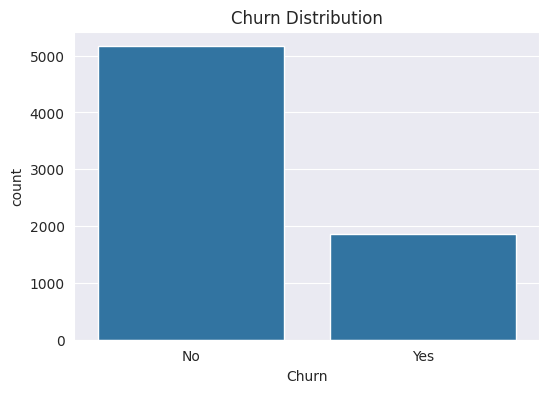

/tmp/ipykernel_112276/509581775.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn']=='No'][col], label='No', shade=True)
/tmp/ipykernel_112276/509581775.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn']=='Yes'][col], label='Yes', shade=True)


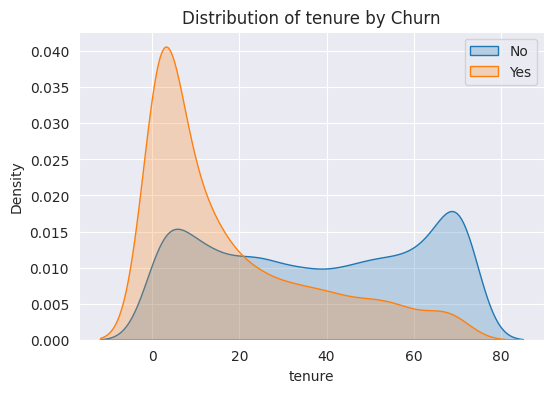

/tmp/ipykernel_112276/509581775.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn']=='No'][col], label='No', shade=True)
/tmp/ipykernel_112276/509581775.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn']=='Yes'][col], label='Yes', shade=True)


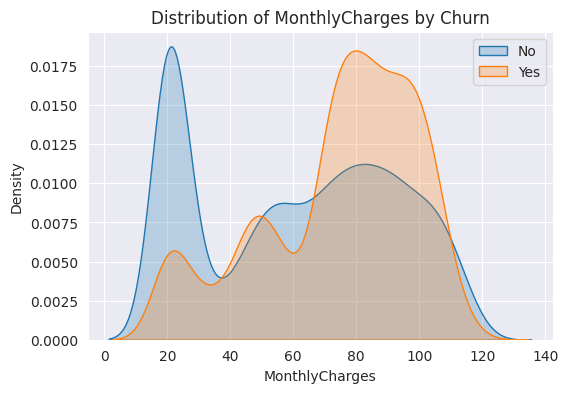

/tmp/ipykernel_112276/509581775.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn']=='No'][col], label='No', shade=True)
/tmp/ipykernel_112276/509581775.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Churn']=='Yes'][col], label='Yes', shade=True)


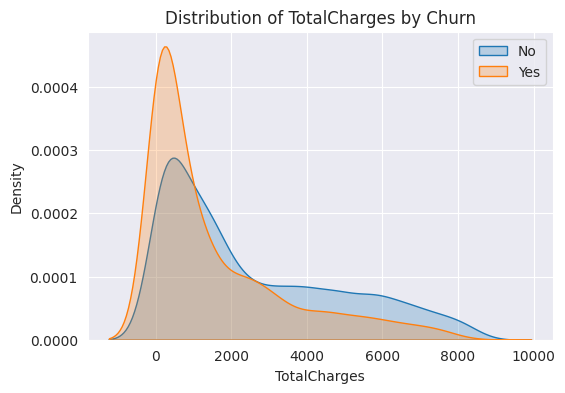

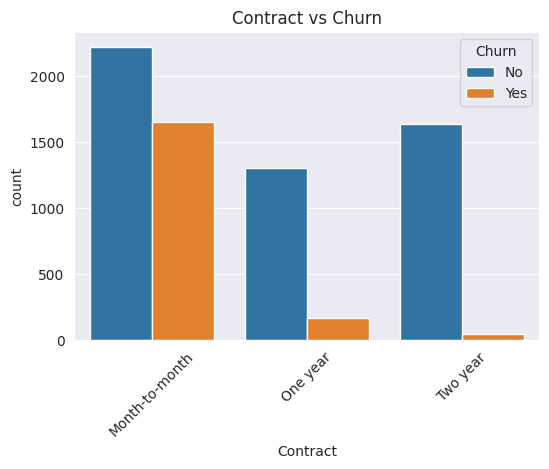

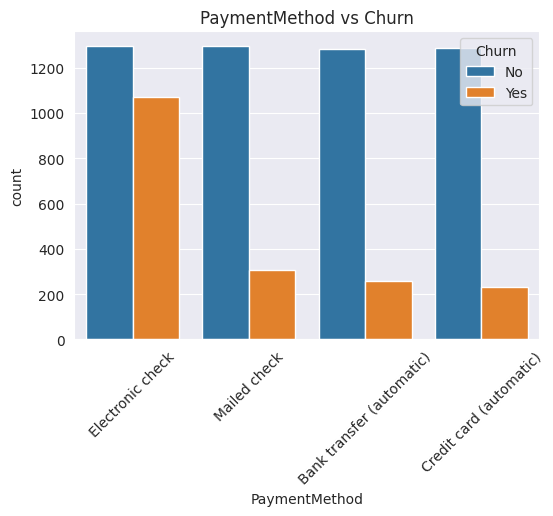

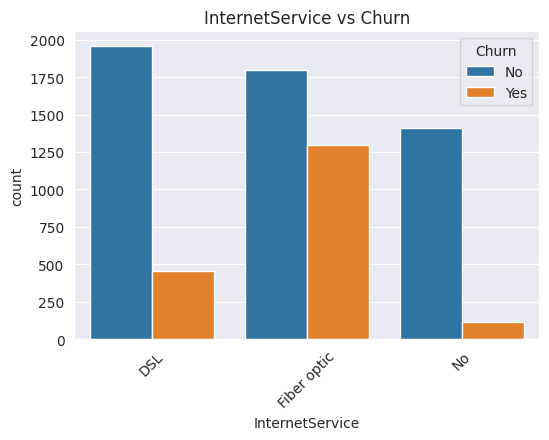

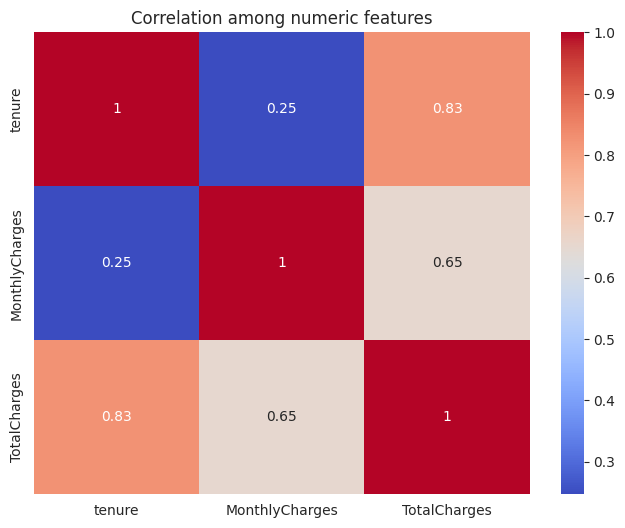

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# 4.2 Numeric feature distributions by churn
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(df[df['Churn']=='No'][col], label='No', shade=True)
    sns.kdeplot(df[df['Churn']=='Yes'][col], label='Yes', shade=True)
    plt.title(f'Distribution of {col} by Churn')
    plt.legend()
    plt.show()

# 4.3 Categorical feature counts
cat_cols = ['Contract', 'PaymentMethod', 'InternetService']
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.show()

# 4.4 Correlation heatmap (numeric)
plt.figure(figsize=(8,6))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation among numeric features')
plt.show()

# 5. Data Preprocessing & Encoding
# ---------------------------------
# 5.1 Drop customerID

In [8]:
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# 5.2 Encode binary categorical variables
binary_cols = [col for col in df.columns
               if df[col].dtype=='object' and df[col].nunique()==2]
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 5.3 One-hot encode remaining categoricals
multi_cols = [col for col in df.select_dtypes('object').columns]
df = pd.get_dummies(df, columns=multi_cols, drop_first=True)

# 5.4 Separate features and target
y = df['Churn']
X = df.drop('Churn', axis=1)

# 6. Feature Selection
# --------------------

In [9]:
selector = SelectKBest(score_func=chi2, k=12)
selector.fit(X.abs(), y)
selected_features = X.columns[selector.get_support()].tolist()
print("Selected features by Chi2:", selected_features)
X_selected = X[selected_features]

# 7. Train/Test Split and Scaling
# --------------------------------

Selected features by Chi2: ['tenure', 'MonthlyCharges', 'TotalCharges', 'InternetService_Fiber optic', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service', 'StreamingMovies_No internet service', 'Contract_Two year', 'PaymentMethod_Electronic check']


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Model Training with Hyperparameter Tuning
# --------------------------------------------

In [19]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

param_grids = {
    'KNN': {'n_neighbors': [3, 5, 7, 9]},
    'DecisionTree': {'max_depth': [None, 5, 10, 15]},
    'RandomForest': {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]},
    'GradientBoosting': {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]},
    'LogisticRegression': {'C': [0.01, 0.1, 1, 10]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
}

results = {}
for name, model in models.items():
    print(f"Tuning and training {name}...")
    grid = GridSearchCV(model, param_grids[name],
                        cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    X_train_input = X_train_scaled if name in ['KNN', 'SVM'] else X_train
    grid.fit(X_train_input, y_train)
    best = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")
    X_test_input = X_test_scaled if name in ['KNN', 'SVM'] else X_test
    y_pred = best.predict(X_test_input)
    y_proba = best.predict_proba(X_test_input)[:, 1]
    results[name] = {
        'model': best,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    print(classification_report(y_test, y_pred))
    print('-' * 40)

# 9. Compare Model Performance
# ----------------------------

Tuning and training LogisticRegression...


/home/faramarz/Documents/University/BAU COMPUTER ENG/DataMining/Project/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/faramarz/Documents/University/BAU COMPUTER ENG/DataMining/Project/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation

Best params for LogisticRegression: {'C': 0.1}
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1549
           1       0.65      0.49      0.56       561

    accuracy                           0.79      2110
   macro avg       0.74      0.70      0.71      2110
weighted avg       0.78      0.79      0.78      2110

----------------------------------------
Tuning and training KNN...
Best params for KNN: {'n_neighbors': 9}
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1549
           1       0.59      0.47      0.52       561

    accuracy                           0.77      2110
   macro avg       0.71      0.68      0.69      2110
weighted avg       0.76      0.77      0.76      2110

----------------------------------------
Tuning and training DecisionTree...
Best params for DecisionTree: {'max_depth': 5}
              precision    recall  f1-score   support

           0

                    accuracy  precision    recall        f1   roc_auc
LogisticRegression  0.793839   0.647196  0.493761  0.560162  0.829408
KNN                 0.772986   0.591928  0.470588  0.524330  0.789435
DecisionTree        0.772038   0.595694  0.443850  0.508682  0.807541
RandomForest        0.781991   0.618824  0.468806  0.533469  0.812814
GradientBoosting    0.790521   0.645477  0.470588  0.544330  0.830874
SVM                 0.794787   0.663265  0.463458  0.545645  0.769123


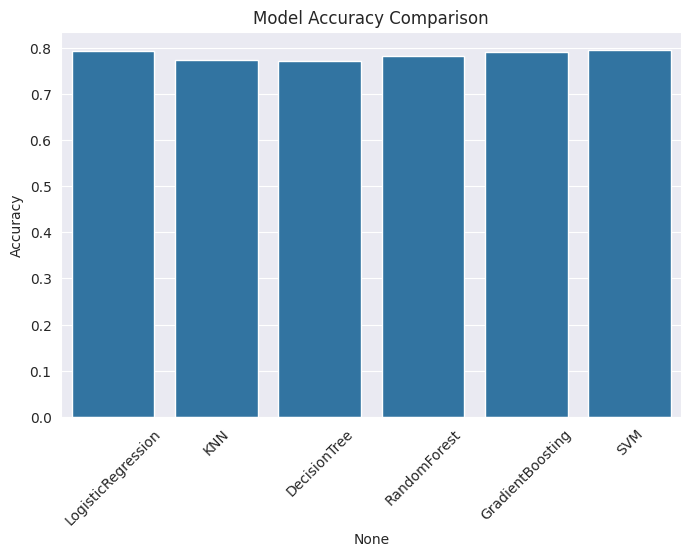

In [12]:
perf_df = pd.DataFrame({k: {m:v for m,v in res.items() if m!='model'}
                        for k,res in results.items()}).T
print(perf_df)
plt.figure(figsize=(8,5))
sns.barplot(x=perf_df.index, y='accuracy', data=perf_df)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# 10. ROC Curves
# --------------

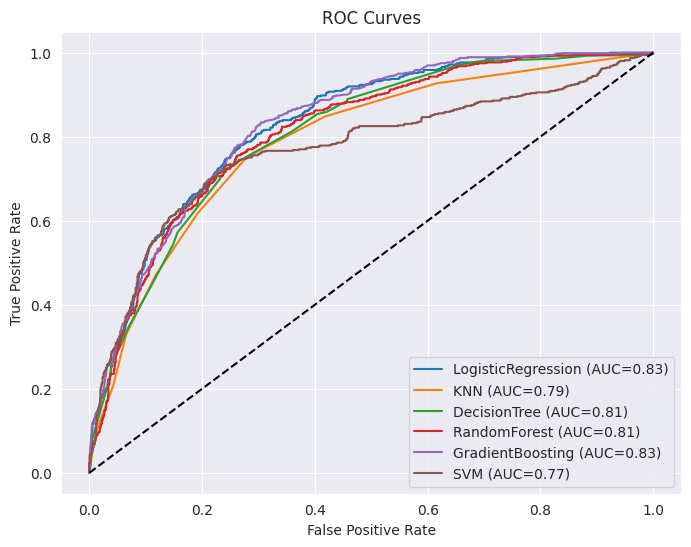

In [13]:
plt.figure(figsize=(8,6))
for name, res in results.items():
    proba = res['model'].predict_proba(
        X_test_scaled if name in ['KNN','SVM'] else X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['roc_auc']:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 11. Unsupervised Clustering for Segmentation
# -------------------------------------------
# Use scaled features for clustering

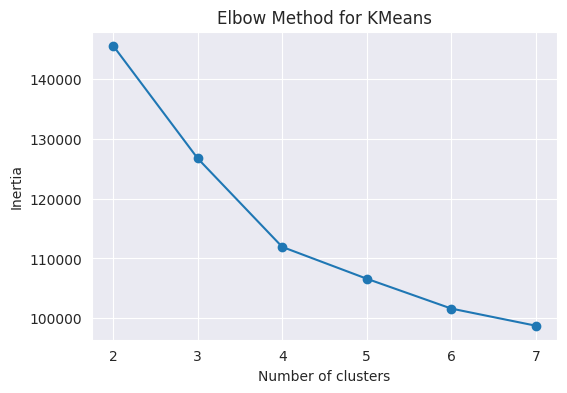

In [14]:
X_cluster = scaler.fit_transform(df.drop('Churn', axis=1))
# Elbow method
inertia = []
for k in range(2,8):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_cluster)
    inertia.append(km.inertia_)
plt.figure(figsize=(6,4))
plt.plot(range(2,8), inertia, marker='o')
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


# Silhouette scores

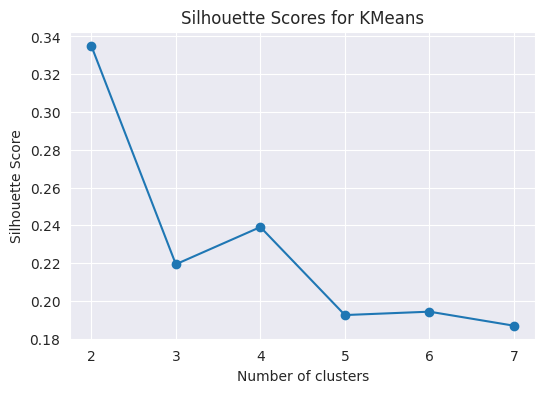

In [15]:
scores = [silhouette_score(X_cluster, KMeans(n_clusters=k, random_state=42).fit_predict(X_cluster))
          for k in range(2,8)]
plt.figure(figsize=(6,4))
plt.plot(range(2,8), scores, marker='o')
plt.title('Silhouette Scores for KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


# Choose optimal k (e.g., where silhouette peaks)

In [16]:
k_opt = int(range(2,8)[np.argmax(scores)])
kmeans = KMeans(n_clusters=k_opt, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)


# Analyze cluster profiles

In [17]:
cluster_profiles = df.groupby('Cluster')[['tenure','MonthlyCharges','TotalCharges','Churn']].mean()
print(cluster_profiles)


            tenure  MonthlyCharges  TotalCharges     Churn
Cluster                                                   
0        32.905479       76.855053   2729.505406  0.318578
1        30.667763       21.076283    665.220329  0.074342
